In [27]:
import pandapower as pp

import numpy as np
import cvxpy as cp
import networkx as nx
import mosek

from solution_files_manager import SolutionFilesManager
from opt_utils import *
from opf_utils import *

In [28]:
import os
folder = os.path.abspath(os.getcwd())

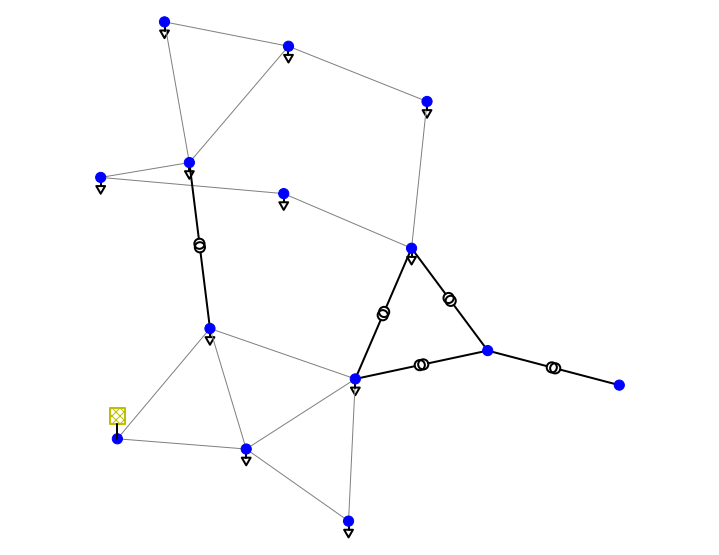

In [29]:
case = "case14"
net, n, gen_df, n_gen, gens, load_df, graph, G_val, B_val, Y_val = load_pp_network(case)

In [30]:
net.bus

,in_service,max_vm_pu,min_vm_pu,name,type,vn_kv,zone
0,True,1.06,0.94,1,b,135.000,1.0
1,True,1.06,0.94,2,b,135.000,1.0
2,True,1.06,0.94,3,b,135.000,1.0
3,True,1.06,0.94,4,b,135.000,1.0
4,True,1.06,0.94,5,b,135.000,1.0
5,True,1.06,0.94,6,b,0.208,1.0
6,True,1.06,0.94,7,b,14.000,1.0
7,True,1.06,0.94,8,b,12.000,1.0
8,True,1.06,0.94,9,b,0.208,1.0
9,True,1.06,0.94,10,b,0.208,1.0


## Variables & parameters

In [31]:
X = cp.Variable((n,n), hermitian=True)

In [32]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [33]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [34]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter(n_gen, value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva ** 2), nonneg=True)
c_p_1 = cp.Parameter(n_gen, value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter(n_gen, value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter(n_gen, value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva ** 2), nonneg=True)
c_q_1 = cp.Parameter(n_gen, value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter(n_gen, value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [35]:
# TODO: if we'd like to alter admittance values and repeat experiments, we'll need to make these into Parameters
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y_val
    Phi_i = 1 / 2 * (Y_i.conj().T + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.conj().T - Y_i)
    Psis.append(Psi_i)

## SDP (QCQP)

In [36]:
constraints = [ X >> 0 ]

for i in range(n):
    # TODO: multiple generators at one bus (however, this almost never happens)
    if i in gens:
        i_gen_idx = gens.index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [37]:
# the power generation costs are not dpp but can be modified
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

loss_cost = cp.sum([ cp.sum([ G[i][j] * cp.real(X[i][i] + X[j][j] - X[i][j] - X[j][i]) for j in range(i)]) for i in range(n)])

In [38]:
# power generation cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# line loss
# prob = cp.Problem(cp.Minimize(loss_cost), constraints)

In [39]:
# prob.solve(solver=cp.SCS, verbose=True)
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jul 11 12:46:20 PM: Your problem has 196 variables, 41 constraints, and 106 parameters.
(CVXPY) Jul 11 12:46:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 11 12:46:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 11 12:46:20 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 11 12:46:20 PM: Reduction chain: EvalParams -> Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jul 11 12:46:20 PM: Applying reduction EvalParams
(CVXPY) Jul 11 12:46:20 PM: Appl

/home/ivanightingale/miniconda3/envs/convex/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


(CVXPY) Jul 11 12:46:20 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 11 12:46:20 PM: Applying reduction MOSEK
(CVXPY) Jul 11 12:46:20 PM: Finished problem compilation (took 3.012e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 11 12:46:20 PM: Invoking solver MOSEK  to obtain a solution.


(CVXPY) Jul 11 12:46:20 PM: Problem
(CVXPY) Jul 11 12:46:20 PM:   Name                   :                 
(CVXPY) Jul 11 12:46:20 PM:   Objective sense        : max             
(CVXPY) Jul 11 12:46:20 PM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Jul 11 12:46:20 PM:   Constraints            : 311             
(CVXPY) Jul 11 12:46:20 PM:   Cones                  : 10              
(CVXPY) Jul 11 12:46:20 PM:   Scalar variables       : 96            

8079.950945019173

In [40]:
np.linalg.eigvalsh(X.value)

array([-1.84102437e-10, -1.73817315e-10, -1.71931213e-10, -1.68544413e-10,
       -1.59710442e-10, -1.41192882e-10, -1.30789844e-10, -8.22289796e-11,
       -5.07094564e-11,  1.04787473e-10,  1.97694259e-07,  6.68028996e-07,
        2.41378364e-03,  1.47606805e+01])

In [41]:
X_val = X.value

In [42]:
recover_verify_solution(prob, X, 1)

1.6228845945973124e-15
[0.]
[0.]
[0.]
[4.89243597e-08]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00090539]
[0.00312549]
[1.5572106e-06]
[0.00153923]
[0.]
[0.]
[0.]
[0.]
[0.00021512]
[0.00461333]
[0.]
[0.]
[0.]
[0.]
[0.00089161]
[4.44115124e-05]
[5.14881593e-06]
[3.46538404e-06]
[1.94363795e-06]
[1.08491809e-06]
[3.65189002e-06]
[9.02881721e-07]
[7.80295443e-06]
[3.40890112e-06]
[8.71665903e-06]
[2.95957331e-06]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [43]:
recover_verify_solution(prob, X, 2)

1.8113899801564426e-15
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[8.28175002e-08]
[2.44415033e-08]
[5.49343672e-08]
[8.39065351e-08]
[0.]
[3.76228503e-08]
[0.]
[0.]
[2.16861419e-08]
[3.69003233e-06]
[0.]
[0.]
[0.]
[0.]
[1.1167437e-07]
[7.11966983e-07]
[3.12613072e-09]
[3.52019497e-09]
[1.83587065e-09]
[1.42546173e-09]
[2.59963456e-09]
[1.37743549e-09]
[5.38743516e-09]
[3.03683828e-09]
[4.46761847e-09]
[1.99479651e-09]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Interior point computation

In [44]:
prob_center = cp.Problem(cp.Maximize( cp.log_det(X)
                                     + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[gens[i]] @ X)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ])
                                     + cp.sum([cp.log(q_max[i] - cp.real(cp.trace(Psis[gens[i]] @ X)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ])
                                     + cp.sum([ cp.log(V_max_sq[i] - cp.real(X[i][i])) + cp.log(cp.real(X[i][i]) - V_min_sq[i]) for i in range(n) ]) ), constraints)

# prob_center.solve(solver=cp.SCS, verbose=True)
prob_center.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jul 11 12:46:20 PM: Your problem has 196 variables, 41 constraints, and 76 parameters.
(CVXPY) Jul 11 12:46:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 11 12:46:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 11 12:46:20 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 11 12:46:20 PM: Reduction chain: Complex2Real -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jul 11 12:46:20 PM: Applying reduction Complex2Real
(CVXPY) Jul 11 12:46:20 PM: Appl

-157.23877844508445

### Fixed point iterations

In [45]:
X_center = X.value

In [46]:
X.value = X_val
fixed_point_iteration(prob, X, -X_center, True)

initial objective: 8079.950945
initial eigenvalues:
[-1.84102437e-10 -1.73817315e-10 -1.71931213e-10 -1.68544413e-10
 -1.59710442e-10 -1.41192882e-10 -1.30789844e-10 -8.22289796e-11
 -5.07094564e-11  1.04787473e-10  1.97694259e-07  6.68028996e-07
  2.41378364e-03  1.47606805e+01]
current objective: 9519.302544
current objective: 9568.594848
current objective: 9573.513715
fixed point objective: 9573.933189
fixed point eigenvalues:
[-2.34900955e-10 -2.30457591e-10 -2.13684677e-10 -2.09310106e-10
 -1.88096947e-10 -1.64569285e-10 -1.46609410e-10 -7.89250030e-11
  9.85072795e-11  5.02431266e-10  1.03532420e-09  2.59308779e-09
  2.24393252e-02  1.51743543e+01]
iterations:  4


array([[[1.1236    +0.00000000e+00j, 1.10503277+5.36670668e-02j,
         1.10021772+1.49127880e-01j, 1.07924187+1.45590221e-01j,
         1.08321796+1.25566322e-01j, 1.07220829+2.33614977e-01j,
         1.07469611+2.10145916e-01j, 1.09243493+2.14406737e-01j,
         1.06155995+2.41007483e-01j, 1.05464935+2.43675382e-01j,
         1.05936812+2.40617267e-01j, 1.05369278+2.46768224e-01j,
         1.04884762+2.46960506e-01j, 1.03291783+2.58340830e-01j],
        [1.10503277-5.36670668e-02j, 1.12359991+0.00000000e+00j,
         1.11920896+9.19826994e-02j, 1.09686171+8.84674893e-02j,
         1.09912512+6.89041855e-02j, 1.09241335+1.75653102e-01j,
         1.09401975+1.51474061e-01j, 1.11074179+1.53989873e-01j,
         1.08217949+1.83241131e-01j, 1.07509871+1.86247233e-01j,
         1.07954254+1.83015519e-01j, 1.07402268+1.89568758e-01j,
         1.06926978+1.90064633e-01j, 1.05379151+2.02165890e-01j],
        [1.10021772-1.49127880e-01j, 1.11920896-9.19826994e-02j,
         1.12359997+0.0

In [47]:
recover_verify_solution(prob, X, 1)

2.9423641208205723e-15
[0.]
[0.]
[0.]
[0.47952735]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.0029396]
[0.]
[0.00081386]
[0.00209723]
[0.00237428]
[0.00183856]
[0.]
[0.00011383]
[0.]
[0.]
[8.62511083e-05]
[8.16102445e-05]
[0.]
[0.00022978]
[0.]
[0.]
[0.00011146]
[5.09130295e-06]
[3.30883866e-05]
[3.67072314e-05]
[3.08628883e-05]
[2.7084213e-05]
[2.48897151e-05]
[2.26186862e-05]
[2.74620132e-05]
[2.38622853e-05]
[2.08693139e-05]
[2.83531326e-05]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [48]:
recover_verify_solution(prob, X, 2)

1.0773683929418147e-15
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[2.5419038e-09]
[5.19080393e-09]
[2.76862019e-10]
[3.94265774e-09]
[0.]
[0.]
[2.39875636e-09]
[0.]
[4.54991322e-11]
[3.70446873e-09]
[0.]
[0.]
[0.]
[0.]
[1.27481764e-09]
[5.27196406e-09]
[1.12851276e-09]
[3.07299092e-09]
[5.88173371e-10]
[1.8102375e-09]
[6.24760299e-10]
[6.84611687e-10]
[1.35066525e-09]
[2.1051067e-09]
[4.61889166e-10]
[8.61511931e-10]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Hyperplane rounding

In [49]:
def cost_from_exact_solution(v):
    X_exact = np.outer(v, v.conj())
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [50]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

7733.405573724656


/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  p_g[i] = p_d[i][0] + G[i][i] * X[i][i] + np.sum(
/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  q_g[i] = q_d[i][0] - B[i][i] * X[i][i] + np.sum(


In [51]:
check_power_feasibility(np.outer(hyperplane_v, hyperplane_v.conj()), p_min.value, p_max.value, q_min.value, q_max.value, gens, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

reactive power generation 0 is too low: q_g = -0.293847 < 0.000000


In [52]:
# sfm = SolutionFilesManager(folder, case, "pp")
# a = sfm.load_solution()
# v = a[1]
# X.value = np.outer(v, v.conj())
#
# for c in prob.constraints:
#     print(c.violation())

In [53]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X.value, None, None)